<a href="https://colab.research.google.com/github/MuYaLkuTty/E-Commerce-Customer-Segmenatation/blob/main/E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E Commerce Customer *Segmentation*

# 1.Data Loading & Preparation:*italicized text*

## *This section loads the dataset and cleans it by handling missing values and creating new features.*

In [1]:
#importing required liabraies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBRegressor
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

In [2]:
# Load Data
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    df.dropna(subset=['CustomerID', 'Description'], inplace=True)
    df.drop_duplicates(inplace=True)
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    df['TotalSales'] = df['Quantity'] * df['UnitPrice']
    return df

In [3]:
# File path (update before running)
file_path = "/content/data.csv"
df = load_data(file_path)

In [4]:
df.head(1)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalSales  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.3

In [5]:

# Summary stats
print(df.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 12:02:00       1.950000   
75%        12.000000            2011-10-20 12:53:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.492832                            NaN      22.241836   

          CustomerID     TotalSales  
count  392692.000000  392692.000000  
mean    15287.843865      22.631500  
min     12346.000000       0.001000  
25%     13955.000000       4.950000  
50%     15150.000000      12.450000  
75%     16791.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.539549     311.099224  


# 2.EDA (Exploratory Data Analysis)

This section explores the dataset, providing summaries, visualizations, and checks for missing values.italicized text

In [6]:
# Check for missing values and data types
col_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'column type'})  # Check column types
# Use pd.concat instead of append
col_info = pd.concat([col_info, pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'null values (nb)'})])  # Check missing values
col_info = pd.concat([col_info, pd.DataFrame(df.isnull().sum() / df.shape[0] * 100).T.rename(index={0: 'null values (%)'})])  # Check missing values in percentage
col_info

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country TotalSales  
column type        float64    float64  object    float64  
null values (nb)         0          0       0          0  
null values (%)        0.0        0.0     0.0        0.0

In [7]:
# Summary statistics
print(df.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 12:02:00       1.950000   
75%        12.000000            2011-10-20 12:53:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.492832                            NaN      22.241836   

          CustomerID     TotalSales  
count  392692.000000  392692.000000  
mean    15287.843865      22.631500  
min     12346.000000       0.001000  
25%     13955.000000       4.950000  
50%     15150.000000      12.450000  
75%     16791.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.539549     311.099224  


In [8]:
# Plot the distribution of TotalSales

fig = px.histogram(df, x='TotalSales', nbins=50, title='Distribution of Total Sales',
                   labels={'TotalSales': 'Total Sales'},
                   marginal='box',  # Optional: adds a box plot on top
                   opacity=0.75)

fig.update_layout(
    xaxis_title='Total Sales',
    yaxis_title='Frequency',
    bargap=0.1
)

fig.show()


In [9]:
# Plot the distribution of Quantity
fig = px.histogram(df, x='Quantity', nbins=50,
                   title='Distribution of Quantity',
                   labels={'Quantity': 'Quantity'},
                   marginal='box',  # Optional: adds a box plot on the side
                   opacity=0.75)
fig.update_layout(
    xaxis_title='Quantity',
    yaxis_title='Frequency',
    bargap=0.1,
    template='plotly_dark'  # or 'plotly_white' based on your preference
)
fig.show()

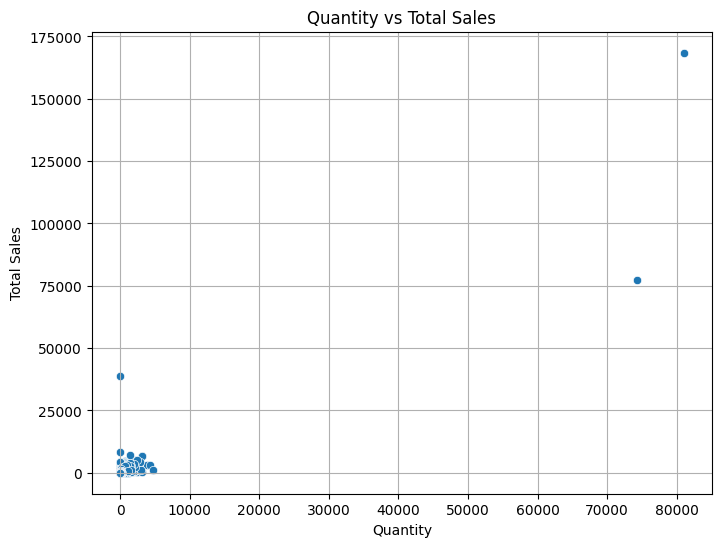

In [10]:
#Quantity VS Total Sales
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Quantity', y='TotalSales')
plt.title('Quantity vs Total Sales')
plt.xlabel('Quantity')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# 3.RFM **Analysis**

In this part, we perform Recency, Frequency, and Monetary (RFM) analysis to segment the customers based on their buying behavior.*italicized text*

In [11]:
# RFM Analysis
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSales': 'sum'
})


In [12]:

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.dropna(inplace=True)
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['Tenure'] = (snapshot_date - df.groupby('CustomerID')['InvoiceDate'].min()).dt.days

# 4.Feature Scaling & Clustering

Here, we scale the data for clustering and perform KMeans clustering on the RFM data.*italicized text*

In [13]:
# Feature Engineering (Example - Average Basket Size)
df['BasketSize'] = df.groupby('InvoiceNo')['StockCode'].transform('count')
rfm['AvgBasketSize'] = df.groupby('CustomerID')['BasketSize'].mean()


In [14]:
# Scaling Data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [15]:

# KMeans Clustering
silhouettes = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    silhouettes.append(silhouette_score(rfm_scaled, kmeans.labels_))
optimal_k = silhouettes.index(max(silhouettes)) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

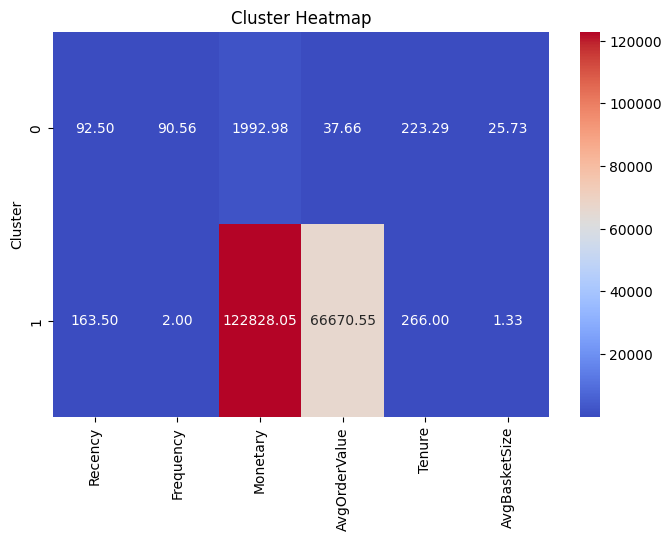

In [16]:
# Visualization 1: Cluster Distribution (Heatmap)
plt.figure(figsize=(8,5))
sns.heatmap(rfm.groupby('Cluster').mean(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Cluster Heatmap")
plt.show()

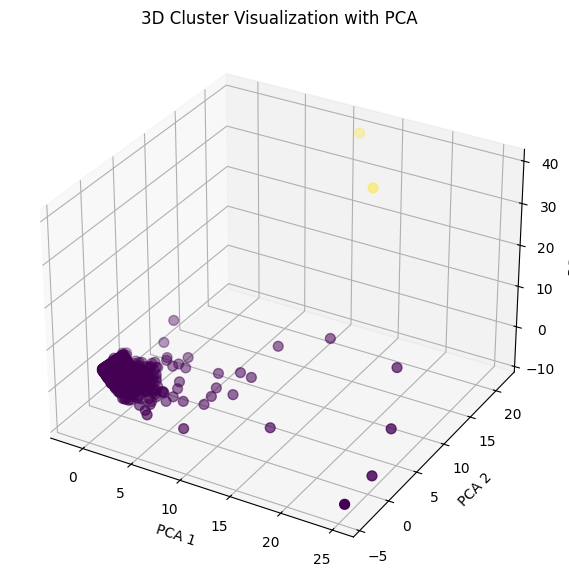

In [17]:
# Visualization 2: 3D Clustering with PCA (Principal Component Analysis)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(rfm_scaled)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=rfm['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title("3D Cluster Visualization with PCA")
plt.show()

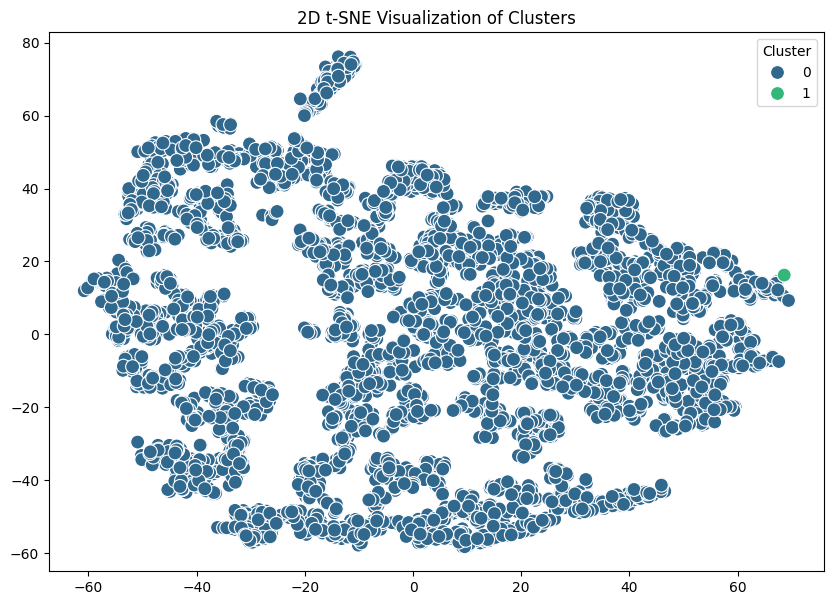

In [18]:
# Visualization 3: 2D t-SNE Clustering
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(rfm_scaled)
plt.figure(figsize=(10,7))
sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1], hue=rfm['Cluster'], palette="viridis", s=100)
plt.title("2D t-SNE Visualization of Clusters")
plt.show()

# 5.Product Similarity Analysis

This section calculates the similarity between products using NLP techniques (BERT embeddings and cosine similarity).*italicized text*

In [ ]:
# Product Similarity (BERT + Cosine Similarity)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['BERT_Embeddings'] = df['Description'].apply(lambda x: model.encode(x))

def get_similar_products(product_desc):
    product_vector = model.encode([product_desc])
    distances = [cosine(product_vector, vec) for vec in df['BERT_Embeddings']]
    df['Similarity'] = distances
    return df.nsmallest(5, 'Similarity')[['StockCode', 'Description']]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 6.CLV Prediction

This step uses a regression model (XGBRegressor) to predict the Customer Lifetime Value (CLV).*italicized text*

In [ ]:
# CLV Prediction
X = rfm[['Recency', 'Frequency', 'AvgOrderValue', 'Tenure']]
y = rfm['Monetary']
clv_model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
clv_model.fit(X, y)
rfm['Predicted CLV'] = clv_model.predict(X)

In [ ]:
# Save Models
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(clv_model, "clv_model.pkl")

In [ ]:
# Visualization 4: Predicted CLV Distribution
plt.figure(figsize=(8,6))
sns.histplot(rfm['Predicted CLV'], kde=True, color='skyblue')
plt.title("Distribution of Predicted Customer Lifetime Value (CLV)")
plt.show()

In [ ]:
# Save Results
print(rfm.head())


In [ ]:

# Insights
print(f"Optimal number of clusters: {optimal_k}")
print(f"Cluster centers: \n{rfm.groupby('Cluster').mean()}")
# Example insights visualization
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary Distribution by Cluster')
plt.show()


In [ ]:

# Example predictions for CLV
# Access 'CustomerID' from the index using .index and reset_index to avoid length mismatch
print(f"Predicted CLV for first few customers: \n{rfm[['Predicted CLV']].head().set_index(rfm.head().index.to_series().rename('CustomerID'))}")